# Topics

In this document, we will go over the topics for reddit and twitter and explore the word probabilities, barplots, visualizations, and word clouds associated with each topic. This helps the reader better understand the distribution of the centroids of conversation around COVID in US.

## Preparations

In [1]:
from io import StringIO
import pandas
import numpy
import os
import gc
import re
import pickle, json
from tqdm import tqdm
from copy import deepcopy
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from datetime import datetime, date, timedelta
import plotnine as p9
import plotly.express as px
import plotly.graph_objects as go
from scipy import signal
from typing import Dict, Tuple, List, Any
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis
import warnings
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV, train_test_split
import gensim, spacy, nltk, re
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

warnings.simplefilter("ignore", DeprecationWarning)
sns.set_style("whitegrid", {'axes.grid' : False})

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



## Twitter

In [2]:
with open('train_test.pkl', 'rb') as handle:
    datasets = pickle.load(handle)
    train_df = datasets['train'].copy()
    del datasets['train']
    test_df = datasets['test'].copy()
    del datasets['test']
    gc.collect()
    
count_vectorizer = CountVectorizer(stop_words='english', min_df=50, ngram_range=(1, 3))
count_data = count_vectorizer.fit_transform(train_df['cleaned_tweet_lemmatized'])
count_data_test = count_vectorizer.transform(test_df['cleaned_tweet_lemmatized'])

In [3]:
with open('lda_twitter/lda_gridsearch/22topics.pkl', 'rb') as handle:
    ckpt = pickle.load(handle)

lda_model_from_ckpt = ckpt['lda_model']

/home/anonymous/mypy/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning:

Trying to unpickle estimator LatentDirichletAllocation from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.



In [4]:
print("hold-out perplexities for:\nlda_model_from_ckpt: {:.4f}".format(
    lda_model_from_ckpt.perplexity(count_data_test)
))

hold-out perplexities for:
lda_model_from_ckpt: 6047.6409


In [5]:
descriptions = [
    "health-care facilities",
    "covid disease",
    "quarantine in relation to activities",
    "stay at home and cleaning",
    "stay at home and gratefulness",
    "china-related affairs",
    "mask",
    "work at home",
    "symptoms and cure",
    "miss",
    "social distancing",
    "quarantine",
    "family and friends",
    "US",
    "trump",
    "school",
    "games",
    "waves and vaccine",
    "news",
    "testing and positivity rates",
    "plans",
    "pandemic (global affairs)"
]

In [6]:
for i, label in enumerate(descriptions):
    print(f"{i+1}: {label}")

1: health-care facilities
2: covid disease
3: quarantine in relation to activities
4: stay at home and cleaning
5: stay at home and gratefulness
6: china-related affairs
7: mask
8: work at home
9: symptoms and cure
10: miss
11: social distancing
12: quarantine
13: family and friends
14: US
15: trump
16: school
17: games
18: waves and vaccine
19: news
20: testing and positivity rates
21: plans
22: pandemic (global affairs)


In [7]:
vocab = count_vectorizer.get_feature_names()

topic_word_probabilities = dict()
words = {}
n_top_words = 150
n_seaborn_probs = 10

for topic, component in enumerate(lda_model_from_ckpt.components_):
    indices = np.argsort(component)[::-1][:n_top_words]
    words[topic] = [vocab[i] for i in indices]
    
    normalized_component = component / component.sum()
    topic_word_probabilities[topic + 1] = pandas.DataFrame({
        'prob': normalized_component[indices[:n_seaborn_probs]],
        'term': [vocab[i] for i in indices[:n_seaborn_probs]],
    }).set_index('term')

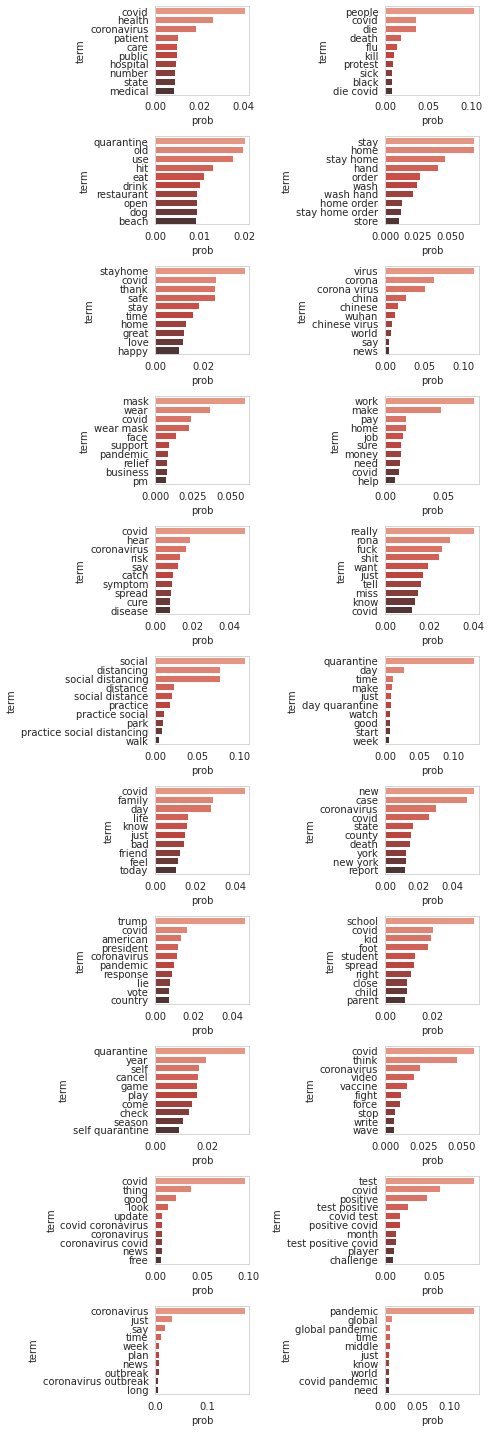

In [8]:
plt.figure(figsize=(7, 20))

for topic_i in topic_word_probabilities:
    df = topic_word_probabilities[topic_i]
    plt.subplot(11, 2, topic_i)
    sns.barplot(x='prob', y=df.index, data=df, palette='Reds_d')
    
plt.tight_layout() 
#plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plt.savefig("twitter_topic_barplots_full.png", dpi=300)

In [9]:
vocab = count_vectorizer.get_feature_names()

topic_word_probabilities = dict()
words = {}
n_top_words = 150
n_seaborn_probs = 150

for topic, component in enumerate(lda_model_from_ckpt.components_):
    indices = np.argsort(component)[::-1][:n_top_words]
    words[topic] = [vocab[i] for i in indices]
    
    normalized_component = component / component.sum()
    topic_word_probabilities[topic + 1] = pandas.DataFrame({
        'prob': normalized_component[indices[:n_seaborn_probs]],
        'term': [vocab[i] for i in indices[:n_seaborn_probs]],
    }).set_index('term')
    
wordclouds = dict()
for topic in words:
    wordclouds[topic + 1] = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(topic_word_probabilities[topic + 1].to_dict()['prob'])

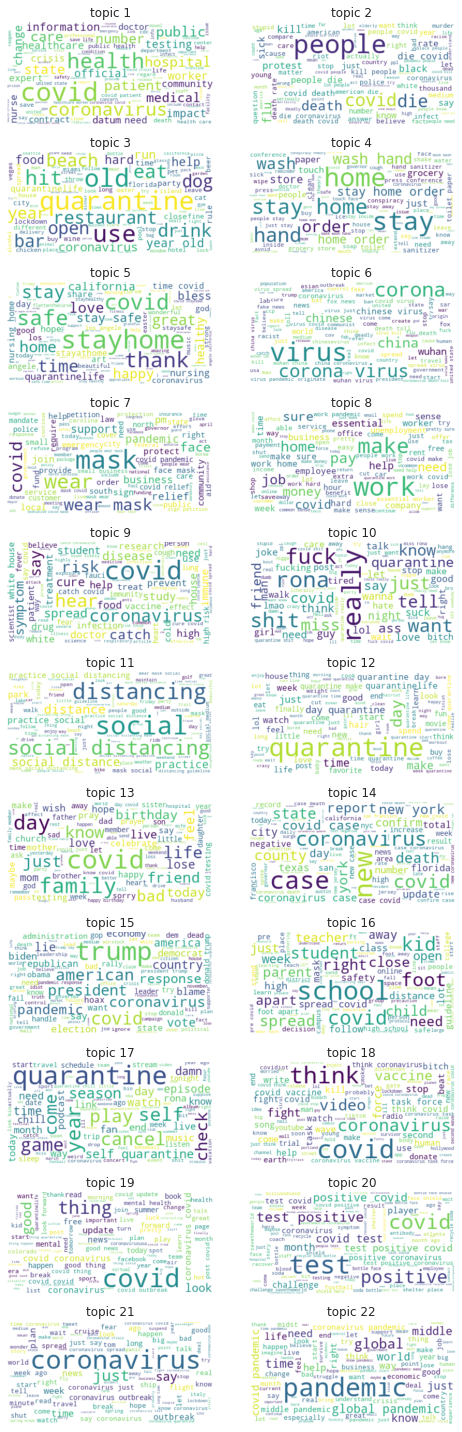

In [10]:
plt.figure(figsize=(7, 20))

for topic_i in wordclouds:
    plt.subplot(11, 2, topic_i)
    plt.title("topic %d" % topic_i)
    plt.imshow(wordclouds[topic_i], interpolation="bilinear")
    plt.axis('off')
    
plt.tight_layout() 

#plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plt.savefig("twitter_topic_wordclouds_full.png", dpi=300)

## Reddit

In [11]:
with open('train_test_reddit.pkl', 'rb') as handle:
    datasets = pickle.load(handle)
    reddit_train_df = datasets['train'].copy()
    reddit_train_df = reddit_train_df[reddit_train_df.cleaned_text.apply(lambda x: isinstance(x, str))]
    del datasets['train']
    reddit_test_df = datasets['test'].copy()
    reddit_test_df = reddit_test_df[reddit_test_df.cleaned_text.apply(lambda x: isinstance(x, str))]
    del datasets['test']
    gc.collect()

In [12]:
reddit_count_vectorizer = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,3))

reddit_count_data = reddit_count_vectorizer.fit_transform(reddit_train_df['cleaned_text_lemmatized'])
reddit_count_data_test = reddit_count_vectorizer.transform(reddit_test_df['cleaned_text_lemmatized'])

In [13]:
with open('reddit_lda_gridsearch/3topics.pkl', 'rb') as handle:
    ckpt = pickle.load(handle)

reddit_lda_model_from_ckpt = ckpt['lda_model']

In [14]:
print("hold-out perplexities for:\nlda_model_from_ckpt: {:.4f}".format(
    reddit_lda_model_from_ckpt.perplexity(reddit_count_data)
))

hold-out perplexities for:
lda_model_from_ckpt: 1609.6286


In [15]:
reddit_vocab = reddit_count_vectorizer.get_feature_names()

reddit_topic_word_probabilities = dict()
reddit_words = {}
n_top_words = 150
n_seaborn_probs = 15

for topic, component in enumerate(reddit_lda_model_from_ckpt.components_):
    indices = np.argsort(component)[::-1][:n_top_words]
    reddit_words[topic] = [reddit_vocab[i] for i in indices]
    
    normalized_component = component / component.sum()
    reddit_topic_word_probabilities[topic + 1] = pandas.DataFrame({
        'prob': normalized_component[indices[:n_seaborn_probs]],
        'term': [reddit_vocab[i] for i in indices[:n_seaborn_probs]],
    }).set_index('term')

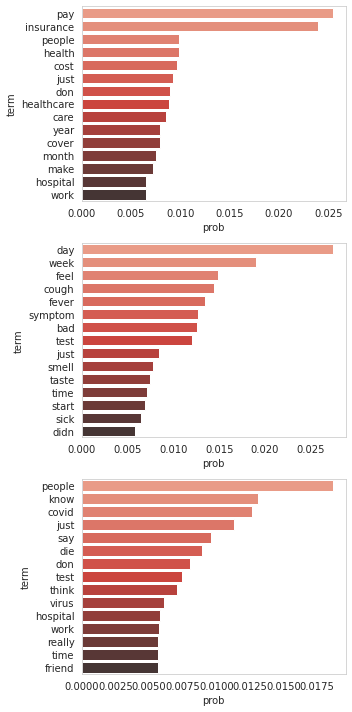

In [16]:
plt.figure(figsize=(5, 10))

for topic_i in reddit_topic_word_probabilities:
    df = reddit_topic_word_probabilities[topic_i]
    plt.subplot(3, 1, topic_i)
    sns.barplot(x='prob', y=df.index, data=df, palette='Reds_d')
    
plt.tight_layout() 
#plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plt.savefig("reddit_topic_barplots_full.png", dpi=300)

In [17]:
reddit_vocab = reddit_count_vectorizer.get_feature_names()

reddit_topic_word_probabilities = dict()
reddit_words = {}
n_top_words = 150
n_seaborn_probs = 150

for topic, component in enumerate(reddit_lda_model_from_ckpt.components_):
    indices = np.argsort(component)[::-1][:n_top_words]
    reddit_words[topic] = [reddit_vocab[i] for i in indices]
    
    normalized_component = component / component.sum()
    reddit_topic_word_probabilities[topic + 1] = pandas.DataFrame({
        'prob': normalized_component[indices[:n_seaborn_probs]],
        'term': [reddit_vocab[i] for i in indices[:n_seaborn_probs]],
    }).set_index('term')
    
reddit_wordclouds = dict()
for topic in reddit_words:
    reddit_wordclouds[topic + 1] = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(reddit_topic_word_probabilities[topic + 1].to_dict()['prob'])

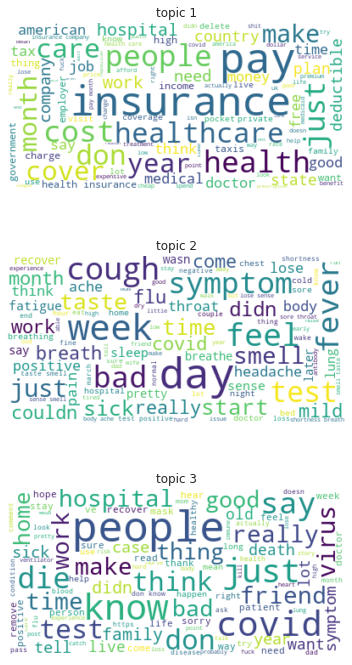

In [18]:
plt.figure(figsize=(5, 10))

for topic_i in reddit_wordclouds:
    plt.subplot(3, 1, topic_i)
    plt.title("topic %d" % topic_i)
    plt.imshow(reddit_wordclouds[topic_i], interpolation="bilinear")
    plt.axis('off')
    
plt.tight_layout() 

#plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plt.savefig("reddit_topic_wordclouds_full.png", dpi=300)
#plt.show()